In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares, calc_width, calc_directness, calc_tempo, calc_possession_time
import seaborn as sns
import pandas as pd

pd.set_option("display.float_format", "{:,.4f}".format)


### Features to use

Main tactical features to use:
- Width offensivly ✅
Average distance from center-line (goal-to-goal) where progressive actions end. 
- Directness ✅
Relationship of progressive actions to non progressive actions
- Tempo ✅
Velocity of ball, how fast do actions happen?
- Pass length

- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar

- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [3]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = load_360_data(actions, three_sixty_only=True)

print("data loaded")

#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


actions = get_progressive_actions(df=df)
prog_passes = actions[actions["is_progressive"] == False]



Loading events: 100%|██████████| 326/326 [00:16<00:00, 19.96it/s]


data loaded


In [4]:
PRESS_EVENTS = {
    "Pressure",
    "Interception",
    "Duel",
    "50/50",
    "Block",
    "Ball Recovery",
    "Foul Committed",
    # optional:
    "Dribbled Past",
}
def calc_pressing_intensity(df_all_events: pd.DataFrame) -> pd.DataFrame:
    """
    Pressing intensity = number of pressing actions while defending
    per minute of opponent possession.

    Returns columns:
      match_id, team_id, n_press_actions, opp_possession_minutes, press_intensity
    """
    df = df_all_events.copy()

    # regular play only (recommended for stability)
    df = df[df["play_pattern"].fillna("Regular Play") == "Regular Play"].copy()

    # pressing actions
    press = df[df["type"].isin(PRESS_EVENTS)].copy()

    # only when opponent owns the possession
    press = press[press["possession_team_id"].notna()].copy()
    press = press[press["possession_team_id"] != press["team_id"]].copy()

    grp = ["match_id", "team_id"]
    counts = press.groupby(grp).size().reset_index(name="n_press_actions")

    # opponent possession minutes = (match total - own possession)
    poss = calc_possession_time(df, match=True)  # match_id, team_id, possession_seconds
    poss["opp_possession_seconds"] = (
        poss.groupby("match_id")["possession_seconds"].transform("sum") - poss["possession_seconds"]
    )
    poss["opp_possession_minutes"] = poss["opp_possession_seconds"] / 60.0

    out = counts.merge(poss[["match_id", "team_id", "opp_possession_minutes"]], on=grp, how="left")
    out["press_intensity"] = out["n_press_actions"] / out["opp_possession_minutes"].replace(0, np.nan)
    return out
def calc_pressing_height(
    df_all_events: pd.DataFrame,
    high_line_x: float = 60.0,
    very_high_line_x: float = 80.0,
    min_press_actions: int = 10,
) -> pd.DataFrame:
    """
    Pressing height features from press-event x locations.

    Returns columns:
      match_id, team_id,
      n_press_actions,
      press_height_mean_x, press_height_median_x, press_height_std_x,
      n_high, press_height_share_high,
      n_very_high, press_height_share_very_high
    """
    df = df_all_events.copy()

    # regular play only
    df = df[df["play_pattern"].fillna("Regular Play") == "Regular Play"].copy()

    press = df[df["type"].isin(PRESS_EVENTS)].copy()

    # only when defending
    press = press[press["possession_team_id"].notna()].copy()
    press = press[press["possession_team_id"] != press["team_id"]].copy()

    # require x
    press = press[press["x"].notna()].copy()

    grp = ["match_id", "team_id"]
    press["is_high"] = press["x"] >= high_line_x
    press["is_very_high"] = press["x"] >= very_high_line_x

    agg = (
        press.groupby(grp)
             .agg(
                 n_press_actions=("x", "size"),
                 press_height_mean_x=("x", "mean"),
                 press_height_median_x=("x", "median"),
                 press_height_std_x=("x", "std"),
                 n_high=("is_high", "sum"),
                 n_very_high=("is_very_high", "sum"),
             )
             .reset_index()
    )

    agg["press_height_share_high"] = agg["n_high"] / agg["n_press_actions"].replace(0, np.nan)
    agg["press_height_share_very_high"] = agg["n_very_high"] / agg["n_press_actions"].replace(0, np.nan)

    # stability: if too few press actions, ratios + moments are noisy
    mask = agg["n_press_actions"] < min_press_actions
    cols_to_nan = [
        "press_height_mean_x", "press_height_median_x", "press_height_std_x",
        "press_height_share_high", "press_height_share_very_high"
    ]
    agg.loc[mask, cols_to_nan] = np.nan

    return agg


In [5]:

assert "is_progressive" in prog_passes.columns
# 1) compute "directness" = progressive share per match/team
press_intensity = calc_pressing_intensity(df)
press_height    = calc_pressing_height(df)


most_press = press_intensity.sort_values("press_intensity", ascending=False).iloc[0]
least_press = press_intensity.sort_values("press_intensity", ascending=True).iloc[0]

print("Most pressing intensity:\n", most_press, "\n")
print("Least pressing intensity:\n", least_press, "\n")


most_high_press = press_height.sort_values("press_height_mean_x", ascending=False).iloc[0]
least_high_press = press_height.sort_values("press_height_mean_x", ascending=True).iloc[0]

print("Highest press:\n", most_high_press, "\n")
print("Lowest press:\n", least_high_press, "\n")


Most pressing intensity:
 match_id                 3,941,018.0000
team_id                        772.0000
n_press_actions                 63.0000
opp_possession_minutes           3.9270
press_intensity                 16.0428
Name: 566, dtype: float64 

Least pressing intensity:
 match_id                 3,938,645.0000
team_id                        782.0000
n_press_actions                 40.0000
opp_possession_minutes          56.3642
press_intensity                  0.7097
Name: 558, dtype: float64 

Highest press:
 match_id                       3,893,827.0000
team_id                              851.0000
n_press_actions                       49.0000
press_height_mean_x                   85.5939
press_height_median_x                 88.3000
press_height_std_x                    17.1889
n_high                                44.0000
n_very_high                           37.0000
press_height_share_high                0.8980
press_height_share_very_high           0.7551
Name: 372, dtyp

In [6]:

def plot_two_pressing_intensity_curves(df, row_a, row_b, max_opp_poss_min=15, labels=None):
    if labels is None:
        labels = ["A", "B"]
    def _get_press_curve(df, row, max_opp_poss_min=None):
        sub = df[
            (df["match_id"] == row["match_id"]) &
            (df["possession_team_id"] != row["team_id"])
        ].copy()

        sub["t"] = pd.to_timedelta(sub["timestamp"])
        sub = sub.sort_values("t")

        # opponent possession time (only within the same possession id)
        sub["t_prev"] = sub["t"].shift(1)
        same_poss = sub["possession"] == sub["possession"].shift(1)
        dt = (sub["t"] - sub["t_prev"]).dt.total_seconds().clip(lower=0)
        sub["opp_poss_dt"] = np.where(same_poss, dt, 0.0)
        sub["cum_opp_poss"] = sub["opp_poss_dt"].cumsum()

        # pressing actions (count only events made by the team of interest)
        sub["is_press"] = (
            (sub["team_id"] == row["team_id"]) &
            (sub["type"].isin(PRESS_EVENTS))
        ).astype(int)
        sub["cum_press"] = sub["is_press"].cumsum()

        if max_opp_poss_min is not None:
            sub = sub[sub["cum_opp_poss"] <= max_opp_poss_min * 60].copy()

        x = sub["cum_opp_poss"].to_numpy() / 60.0
        y = sub["cum_press"].to_numpy()
        return x, y



    x1, y1 = _get_press_curve(df, row_a, max_opp_poss_min=max_opp_poss_min)
    x2, y2 = _get_press_curve(df, row_b, max_opp_poss_min=max_opp_poss_min)

    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, lw=2, label=labels[0])
    plt.plot(x2, y2, lw=2, label=labels[1])

    plt.xlabel("Opponent possession time (minutes)")
    plt.ylabel("Cumulative pressing actions")
    plt.title(f"Pressing intensity comparison (first {max_opp_poss_min} opp poss min)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_two_pressing_height_distributions(df, row_a, row_b, labels=None, bins=30):
    if labels is None:
        labels = ["Team A", "Team B"]

    def get_press_x(row):
        press = df[
            (df["match_id"] == row["match_id"]) &
            (df["team_id"] == row["team_id"]) &
            (df["possession_team_id"] != row["team_id"]) &
            (df["type"].isin(PRESS_EVENTS)) &
            (df["x"].notna())
        ]
        return press["x"].values

    x_a = get_press_x(row_a)
    x_b = get_press_x(row_b)
    mean_a = x_a.mean()
    mean_b = x_b.mean()

    plt.figure(figsize=(8, 6))
    plt.hist(x_a, bins=bins, density=True, alpha=0.6, label=labels[0])
    plt.hist(x_b, bins=bins, density=True, alpha=0.6, label=labels[1])

    plt.axvline(60, color="k", linestyle="--", label="Opponent half")


    plt.axvline(mean_a, color="blue", linestyle="-", linewidth=2)
    plt.axvline(mean_b, color="orange", linestyle="-", linewidth=2)


    plt.xlabel("x-position")
    plt.ylabel("Density")
    plt.title("Pressing height comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


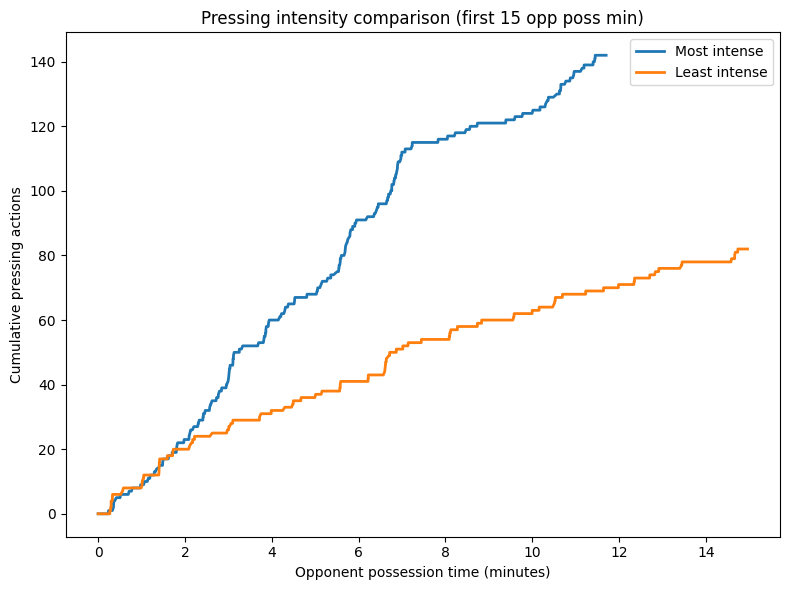

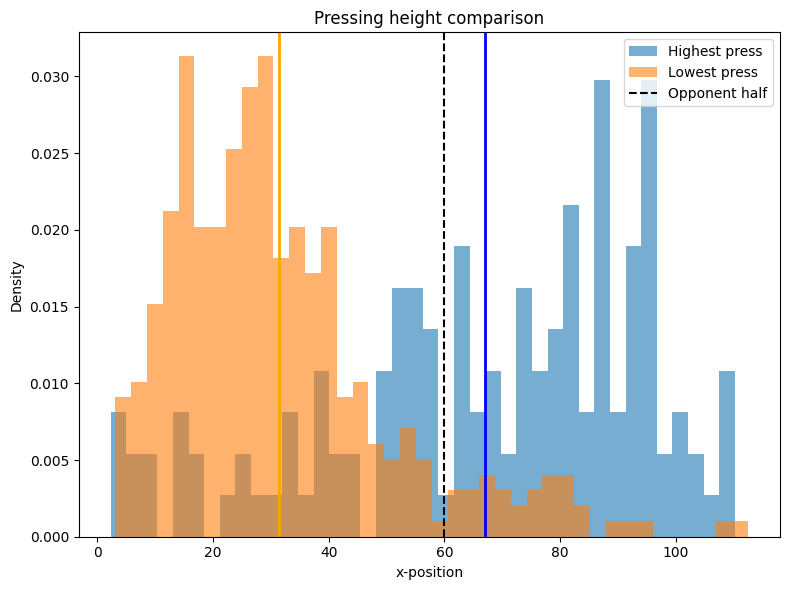

In [7]:
plot_two_pressing_intensity_curves(df, most_press, least_press, labels=["Most intense", "Least intense"])
plot_two_pressing_height_distributions(df, most_high_press, least_high_press, labels=["Highest press", "Lowest press"], bins=40)


=== PRESSING SUMMARY (ALL MATCHES) ===
Mean pressing intensity:   6.270
Median pressing intensity: 6.454

Mean pressing height:      55.311
Median pressing height:    55.392


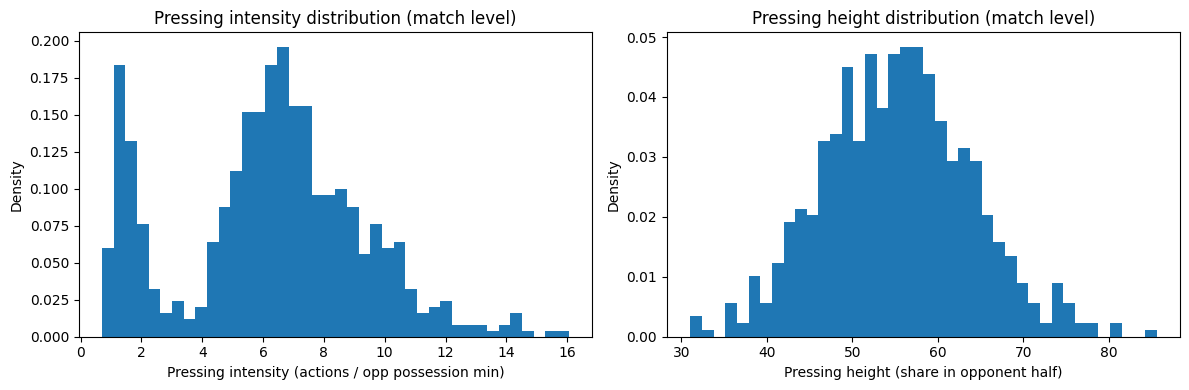

{'press_intensity_mean': 6.270204526377175,
 'press_intensity_std': 3.0360663721117636,
 'press_height_mean': 55.311143692735854,
 'press_height_std': 0     25.7618
 1     27.7034
 2     22.2272
 3     22.9728
 4     24.8798
         ...  
 647   26.3618
 648   21.4136
 649   28.7634
 650   30.7119
 651   31.3682
 Name: press_height_std_x, Length: 652, dtype: float64}

In [11]:
# === PRESSING SUMMARY (MATCH LEVEL) ===

import matplotlib.pyplot as plt

# 1) Compute match-level metrics
press_intensity = calc_pressing_intensity(df)
press_height    = calc_pressing_height(df)

# 2) Summary statistics
mean_press_intensity   = press_intensity["press_intensity"].mean()
median_press_intensity = press_intensity["press_intensity"].median()

mean_press_height   = press_height["press_height_mean_x"].mean()
median_press_height = press_height["press_height_mean_x"].median()

print("=== PRESSING SUMMARY (ALL MATCHES) ===")
print(f"Mean pressing intensity:   {mean_press_intensity:.3f}")
print(f"Median pressing intensity: {median_press_intensity:.3f}")
print()
print(f"Mean pressing height:      {mean_press_height:.3f}")
print(f"Median pressing height:    {median_press_height:.3f}")

# 3) Distributions
plt.figure(figsize=(12, 4))

# Pressing intensity distribution
plt.subplot(1, 2, 1)
plt.hist(
    press_intensity["press_intensity"].dropna(),
    bins=40,
    density=True
)
plt.xlabel("Pressing intensity (actions / opp possession min)")
plt.ylabel("Density")
plt.title("Pressing intensity distribution (match level)")

# Pressing height distribution
plt.subplot(1, 2, 2)
plt.hist(
    press_height["press_height_mean_x"].dropna(),
    bins=40,
    density=True
)
plt.xlabel("Pressing height (share in opponent half)")
plt.ylabel("Density")
plt.title("Pressing height distribution (match level)")

plt.tight_layout()
plt.show()

# 4) Optional: store baseline values for later normalisation / defaults
pressing_baseline = {
    "press_intensity_mean": mean_press_intensity,
    "press_intensity_std": press_intensity["press_intensity"].std(),
    "press_height_mean": mean_press_height,
    "press_height_std": press_height["press_height_std_x"],
}

pressing_baseline
